In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

sns.set_style('darkgrid')
titleFont = FontProperties(weight='bold', size=20)
axisFont = FontProperties(weight='bold', size=14) 

from trading.exchange import BackTestExchange
from trading.dataManager import CurrencyDataManager
from trading.money.contract import ContractPair, Contract
from trading.statistics import Statistics
from trading.money.transaction import BuyTransaction, SellTransaction
from calculator.talibWrapper import calculateTalib

In [2]:
from calculator.talibWrapper import talibFunctionInfo
talibFunctionInfo('BBANDS')

'BBANDS([input_arrays], [timeperiod=5], [nbdevup=2], [nbdevdn=2], [matype=0])\n\nBollinger Bands (Overlap Studies)\n\nInputs:\n    price: (any ndarray)\nParameters:\n    timeperiod: 5\n    nbdevup: 2\n    nbdevdn: 2\n    matype: 0 (Simple Moving Average)\nOutputs:\n    upperband\n    middleband\n    lowerband'

# Load Data

In [3]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataLabeled\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('timestamp').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair('usdt', 'btc')

# Bollinger Bands

Bollinger Bands consist of a moving average and two standard deviations,
one above the moving average and one below. The important thing
to know about Bollinger Bands is that they contain up to 95% of the
closing prices, depending on the settings.

- A buy signal is generated when prices move below the lower Bollinger Band.
- A sell signal is generated when prices move above the upper Bollinger Band.

Source: Markus Heitkoetter: The Complet Guide to Day Trading

In [4]:
data = {
            'close': usdtBtc.head(10)['close'].values,
        }
        
upper, middle, lower = calculateTalib('BBANDS', data, {'timeperiod': 5})

In [5]:
from copy import deepcopy

class BollingerBandsStrategy:
    def __init__(self, exchange, dataManager, historyLen, contractPair, tradeSize, willingLoss, 
                 distFromMiddleThreshold, diffThreshold):
        self.exchange = exchange
        self.walletStart = deepcopy(self.exchange.wallet)
        self.dataManager = dataManager
        self.historyLen = historyLen
        self.contractPair = contractPair
        self.opened = False
        self.tradeSize = tradeSize
        self.willingLoss = willingLoss
        self.distFromMiddleThreshold = distFromMiddleThreshold
        self.diffThreshold = diffThreshold

    def calculateBBands(self, history, col, timePeriod):
        upper, middle, lower = calculateTalib('BBANDS', {col: history[col].values}, {'timeperiod': timePeriod})
        return upper[-1], middle[-1], lower[-1]
    
    
    def isRisky(self, priceBought, actualPrice):
        return self.currentReturn(priceBought, actualPrice) < -self.willingLoss 
    
    
    def currentReturn(self, priceBought, actualPrice):
        return float(actualPrice - priceBought) / priceBought
    
    
    def sellWhole(self, price):
        self.opened = False
        amount = self.exchange.balance(self.contractPair.tradeContract)
        self.exchange.sell(self.contractPair, amount, price)
    
    
    def buy(self, price):
        amount = self.tradeSize / price
        self.exchange.buy(self.contractPair, amount, price)
        self.opened = True
        breakEvenPrice = price + price * self.exchange.fee * 2
        return breakEvenPrice
        
    
    def trade(self):
        
        wasBellow = False
        while self.dataManager.hasTick():            
            history, price = self.dataManager.tick(self.historyLen)
            if history.shape[0] < self.historyLen:
                continue

            upper, middle, lower = self.calculateBBands(history, 'close', self.historyLen)
            
            lastLow = history['low'].iloc[-1]
            lastHigh = history['high'].iloc[-1]
            lastClose = history['close'].iloc[-1]
            lastOpen = history['open'].iloc[-1]
            if not self.opened and wasBellow and price > lower and (upper-lower) / upper < self.diffThreshold:
#                 print(self.dataManager.time, 'openning trade: ', price, end='\t')
                breakEvenPrice = self.buy(price)
                priceBought = price
                wasBellow = False
                
            elif self.opened and self.isRisky(priceBought, price):
#                 print(self.dataManager.time, 'stopLoss: ', price, self.currentReturn(priceBought, price) * 100)
                self.sellWhole(price)
            elif self.opened and (price-middle) / middle > self.distFromMiddleThreshold and price > breakEvenPrice:
#                 print(self.dataManager.time, 'profit: ', price, self.currentReturn(priceBought, price) * 100)
                self.sellWhole(price)

                
            wasBellow = price < lower
                
    def stats(self, contractName):
        return Statistics(contractName, self.walletStart[contractName]).evaluate(self.exchange.transactions)

# Learning

In [43]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = BollingerBandsStrategy(exchange, dataManager, 20, contractPair, 100, willingLoss=0.05, distFromMiddleThreshold=0.01, diffThreshold=0.03)
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,217.0000
totalProfit,-128.6594
avgProfit,-0.5929
winPercentage,81.5668
avgWinTrade,1.2323
avgLossTrade,-6.1631
profitFactor,0.8848
maxDrawdown,4.8932


In [79]:
import time, sys

allStats = None
for historyLen in [15, 20, 30, 50]:
    for willingLoss in [.01, .03, .05, .1, .2, .4, .5]:
        for distFromMiddleThreshold in [.01, .02, .05, .07, .1, .2,]:
            for diffThreshold in [.01, .02, .03]:
                print('historyLen:', historyLen, end='\t')
                print('willingLoss', willingLoss, end='\t')
                print('distFromMiddleThreshold', distFromMiddleThreshold, end='\t')
                print('diffThreshold', diffThreshold, end='\t')
                sys.stdout.flush()
                
                start_time = time.time()
                dataManager = deepcopy(usdtBtcManagerTrain)
                exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
                strategy = BollingerBandsStrategy(exchange, dataManager, historyLen, contractPair, 100, 
                                                  willingLoss=willingLoss, distFromMiddleThreshold=distFromMiddleThreshold, 
                                                  diffThreshold=diffThreshold)
                strategy.trade()
                stats = strategy.stats('usdt').report().transpose().reset_index().rename(columns={'index': 'contract'})
                stats['historyLen'] = historyLen
                stats['willingLoss'] = willingLoss
                stats['distFromMiddleThreshold'] = distFromMiddleThreshold
                stats['diffThreshold'] = diffThreshold
                if allStats is None:
                    allStats = stats
                else:
                    allStats = allStats.append(stats)
                print("%.2f seconds" % (time.time() - start_time))
allStats.to_csv('bbandsResult.tsv', index=False, sep='\t')

historyLen: 415	willingLoss 0.01	distFromMiddleThreshold 0.01	diffThreshold 0.01	71.94 seconds
historyLen: 415	willingLoss 0.01	distFromMiddleThreshold 0.01	diffThreshold 0.02	76.64 seconds
historyLen: 415	willingLoss 0.01	distFromMiddleThreshold 0.01	diffThreshold 0.03	

KeyboardInterrupt: 

# Look on transactions

In [21]:
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

import time
import datetime as dt

def timestampToDate(timestamp):
    return dt.datetime.fromtimestamp(int(timestamp))

def strTimeToTimestamp(strTime):
    return dt.datetime.strptime(strTime, "%Y-%m-%d %H:%M:%S").timestamp()


def calculateMA(history, col, timePeriod):
        return calculateTalib('MA', {col: history[col].values}, {'timeperiod': timePeriod})


def plotCandles(df, currencyPair):
    DATA = df[['open', 'high', 'low', 'close', 'volume', 'date', 'timestamp']].copy()
    DATA = DATA.reset_index()
    DATA["dateStr"] = DATA["date"]
    DATA["date"]  = DATA["timestamp"].apply(timestampToDate).apply(mdates.date2num)

    plt.figure(figsize=(16, 8))
    ax = plt.gca()
    candlestick_ohlc(ax, DATA.values, width=.6, colorup='#53c156', colordown='#ff1717')

    ax.xaxis_date()
    
    xDates = DATA['dateStr']
    step = int(xDates.shape[0] / 20) + 1
    xDates[[i for i in range(xDates.shape[0]) if i % step != 0]] = ''
    
    plt.xticks(range(DATA.shape[0]), DATA['dateStr'], rotation=45)
    plt.title(currencyPair, fontproperties=titleFont)
    

def plotMA(df, col, timeperiod):
    ma = calculateMA(df, col, timeperiod)
    return plt.plot(ma)


def calculateBB(history, col, timePeriod):
        upper, middle, lower = calculateTalib('BBANDS', {col: history[col].values}, {'timeperiod': timePeriod})
        return upper, middle, lower


def plotBB(df, col, timeperiod):
    upper, middle, lower = calculateBB(df, col, timeperiod)
    return plt.plot(upper), plt.plot(middle), plt.plot(lower)


def plotTransaction(transaction, i):
    color = 'k' if type(transaction) == BuyTransaction else 'm'
    plt.scatter(i, transaction.price.value, s=200, c=color)

    
def plotTransactionWithSurroundings(prices, timePeriod, transaction):
    i = transaction.timestamp
    start = i - 40 if i - 20 > 0 else 0
    end = i + 20 if i + 20 < prices.shape[0] else prices.shape[0]-1
    selected = prices.ix[start:end, :].reset_index()
    plotCandles(selected, '')
    plotTransaction(transaction, 39)
    l1, l2, l3 = plotBB(selected, 'close', timePeriod)
    plt.legend(l1+l2+l3, ['Upper', 'Mean', 'Lower'])

In [37]:
len(strategy.exchange.transactions)

506

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


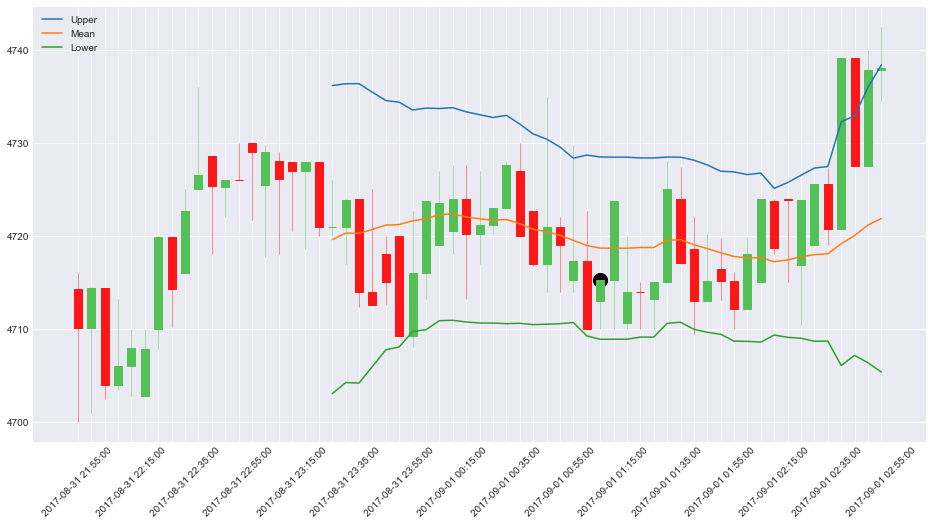

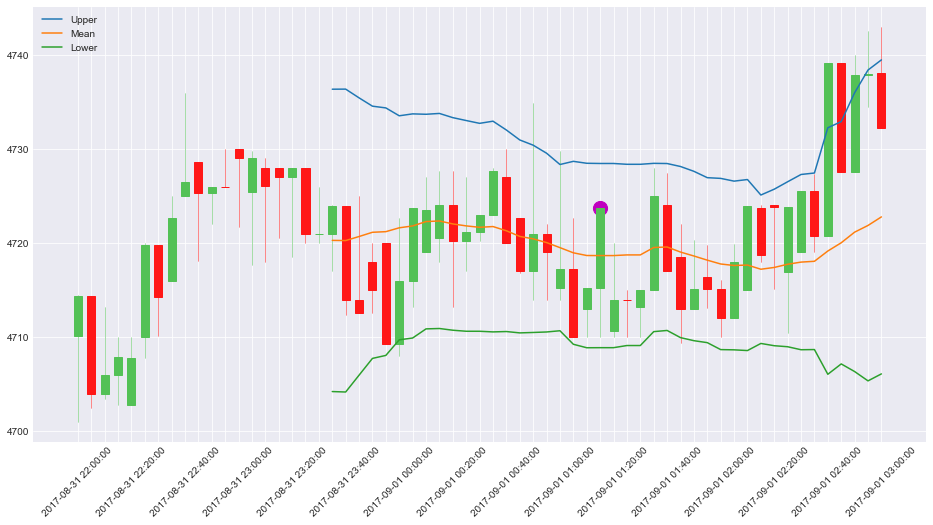

In [38]:
t = 500

transaction = strategy.exchange.transactions[t]
plotTransactionWithSurroundings(usdtBtcTrain, 20, transaction)
transaction = strategy.exchange.transactions[t+1]
plotTransactionWithSurroundings(usdtBtcTrain, 20, transaction)

In [ ]:
transaction

# Evaluate Statistics Crossover MA

In [6]:
allStats = pd.read_csv('D:\\Dropbox\\My work\\krypl-project\\result\\bbandsResult.tsv',sep='\t')

In [16]:
allStats.query('totalProfit > 90 and winPercentage > 50').sort_values('numberOfTrades', ascending=False)

,contract,startAmount,numberOfTrades,totalProfit,avgProfit,winPercentage,avgWinTrade,avgLossTrade,profitFactor,maxDrawdown,historyLen,willingLoss,distFromMiddleThreshold,diffThreshold
273,usdt,"1,000.0000",56.0000,101.8809,1.8193,57.1429,6.0826,-3.8651,2.0983,2.3395,30,0.0300,0.0200,0.0100
205,usdt,"1,000.0000",10.0000,93.2724,9.3272,60.0000,46.0404,-20.6800,3.3395,2.6947,20,0.2000,0.0500,0.0200
206,usdt,"1,000.0000",10.0000,97.4533,9.7453,60.0000,46.7573,-20.7102,3.3865,3.1522,20,0.2000,0.0500,0.0300
79,usdt,"1,000.0000",9.0000,115.9220,12.8802,55.5556,59.7695,-20.6689,3.6147,2.3965,15,0.2000,0.0500,0.0200
80,usdt,"1,000.0000",9.0000,123.5979,13.7331,55.5556,61.3324,-20.7035,3.7030,2.5426,15,0.2000,0.0500,0.0300
204,usdt,"1,000.0000",9.0000,90.1667,10.0185,66.6667,42.0064,-20.5405,4.0901,2.0512,20,0.2000,0.0500,0.0100
78,usdt,"1,000.0000",8.0000,107.7693,13.4712,62.5000,53.9215,-20.5294,4.3776,2.0479,15,0.2000,0.0500,0.0100
96,usdt,"1,000.0000",5.0000,99.2789,19.8558,100.0000,39.9058,0.0000,inf,0.0000,15,0.4000,0.0500,0.0100
114,usdt,"1,000.0000",5.0000,99.2789,19.8558,100.0000,39.9058,0.0000,inf,0.0000,15,0.5000,0.0500,0.0100


In [8]:
dataManager = deepcopy(usdtBtcManagerTest)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)
strategy = BollingerBandsStrategy(exchange, dataManager, 30, contractPair, 100, willingLoss=0.03, distFromMiddleThreshold=0.02, diffThreshold=0.01)
strategy.trade()
strategy.stats('usdt').report()

,usdt
startAmount,"1,000.0000"
numberOfTrades,21.0000
totalProfit,260.8806
avgProfit,12.4229
winPercentage,61.9048
avgWinTrade,42.9565
avgLossTrade,-37.1942
profitFactor,1.8768
maxDrawdown,6.7830


# Distance of lower and upper

In [7]:
def distanceOfBB(df, col='close', timePeriod=20):
    upper, middle, lower = calculateBB(df, col, timePeriod)
    return (upper-lower) / upper

In [8]:
tmpData = usdtBtcTrain.copy()
tmpData['diffBB'] = distanceOfBB(tmpData)

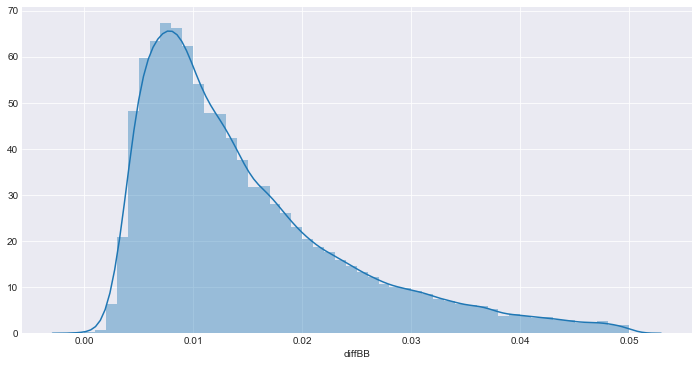

In [17]:
plt.figure(figsize=[12, 6])
sns.distplot(tmpData.query('diffBB < 0.05')['diffBB'].dropna())

# Explore maximum return per day

In [22]:
tmpData = usdtBtc.copy()
tmpData['day'] = tmpData['date'].apply(lambda x: x[:10])
grouped = tmpData[['day', 'close']].groupby('day').aggregate(['min', 'max'])['close'].reset_index()
grouped['maxReturn'] = (grouped['max'] - grouped['min']) / grouped['min']
grouped['maxReturnFloor'] = np.floor(grouped['maxReturn'] * 100)

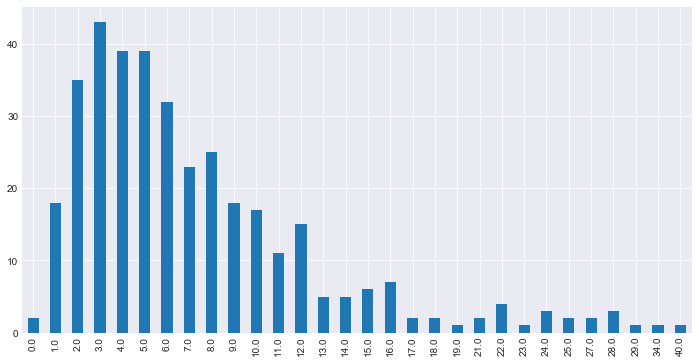

In [27]:
grouped['maxReturnFloor'].value_counts().sort_index().plot(kind='bar', figsize=[12,6])